<a href="https://colab.research.google.com/github/gus474/Deep-Learning-Crop-Identification/blob/main/Copy_of_Assignment_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### 0. Here are the libraries that I used for this assignment

In [ ]:
# Load libraries and modules
import os
import copy
import torch
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import torch.nn as nn
import torch.nn.functional as F

#### 1.a. Load the cherry NIR spectroscopy data

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')

device

device(type='cuda')

In [ ]:
# Read csv file into dataframe
df_cherry = pd.read_table('/content/drive/MyDrive/EBS189A_SINGH_GURTEG/Assignment 7/Copy of cherry_data_spectral.csv', sep=',', index_col='fruit_id')

#### 1.b. Using PyTorch, define a loss function using mean squared error
- Define the function as `mse_loss()` which receives two inputs: `y` and `y_pred`
- What is the role of the loss function in model training via gradient descent?

In [ ]:
mse_loss = nn.MSELoss()

#The mse_loss function that gradient descent tries to iteratively minimize by updatinging model parameters. 

#### 1.c. Define four model architectures using PyTorch based on the diagrams below. Assign them to the following variable names: `MLP_1`, `MLP_1_wide`, `MLP_2`, and `MLP_2_wide`.
- What is meant by the "width" versus "depth" of a neural network?
- What are two key defining properties of deep neural networks (shown in the diagram below) that make them flexible and predictively powerful?

<center><img src='https://drive.google.com/uc?export=view&id=1LVsCXFxUEen_g04bGs-rYL5WFsP6zrcS' width=750></center>

In [ ]:
class MLP1(nn.Module): #creating classes for each type of model
  def __init__(self, inputsize):
    super().__init__()
    self.input = nn.Linear(inputsize, 10)
    self.hl1 = nn.Linear(10, 10)#Hidden layers with 10 nodes
    self.hl2 = nn.Linear(10,10)
    self.out = nn.Linear(10,1)
  def forward(self, x):
    x = self.input(x)
    x = F.relu(x) #Layers of models
    x = self.hl1(x)
    x = F.relu(x)
    x = self.hl2(x)
    x = self.out(x)
    return x

class MLP2(nn.Module):
  def __init__(self, inputsize):
    super().__init__()
    self.input = nn.Linear(inputsize, 10)
    self.hl1 = nn.Linear(10, 10)
    self.hl2 = nn.Linear(10,10)
    self.hl3 = nn.Linear(10,10)#Additional hidden layer of nodes
    self.out = nn.Linear(10,1)
  def forward(self, x):
    x = self.input(x)
    x = F.relu(x) #Additional layer of model (depth)
    x = self.hl1(x)
    x = F.relu(x)
    x = self.hl2(x)
    x = F.relu(x)
    x = self.hl3(x)
    x = self.out(x)
    return x

class MLP_1_wide(nn.Module): #Defining wide models
  def __init__(self, inputsize):
    super().__init__()
    self.input = nn.Linear(inputsize, 50)
    self.hl1 = nn.Linear(50, 50) 
    self.hl2 = nn.Linear(50,50)
    self.out = nn.Linear(50,1)
  def forward(self, x):
    x = self.input(x)
    x = F.relu(x)
    x = self.hl1(x)
    x = F.relu(x)
    x = self.hl2(x)
    x = self.out(x)
    return x

class MLP_2_wide(nn.Module):
  def __init__(self, inputsize):
    super().__init__()
    self.input = nn.Linear(inputsize, 50)
    self.hl1 = nn.Linear(50, 50)
    self.hl2 = nn.Linear(50,50)
    self.hl3 = nn.Linear(50,50)
    self.out = nn.Linear(50,1)
  def forward(self, x):
    x = self.input(x)
    x = F.relu(x)
    x = self.hl1(x)
    x = F.relu(x)
    x = self.hl2(x)
    x = F.relu(x)
    x = self.hl3(x)
    x = self.out(x)
    return x

#### 1.d. Define a dictionary called `model_dict` containing all four models with the keys:

- `MLP_1`
- `MLP_1_wide`
- `MLP_2`
- `MLP_2_wide`

Note that you can store functions as items within a dictionary or a list. In this example, you simply call the function from a dictionary as, for example, `model_dict[MLP_1](...)` with the appropriate arguments.

In [ ]:
model_dict = { #Creating a dictionary for each model
    'MLP_1': MLP1, 
    'MLP_1_wide': MLP_1_wide,
    'MLP_2': MLP2,
    'MLP_2_wide': MLP_2_wide,
}

#### 1.e. For each variety, train a model using each of the architectures that you created above 

- In total there will be 7 varieties x 4 model architectures = 28 total models. Save the best model for each to a folder called `best_models`.
- Create a dictionary, called `results_dict`, to store the model training results with the following hierarchical structure:

```
variety
 |- model_name
      |- train_loss
      |- val_loss
      |- epoch_best_model
      |- val_best_model

where, 
  *variety*: a given cherry variety
  *model_name*: a given model name from model_dict
  *train_loss*: list of training loss values for each epoch
  *val_loss*: list of validation loss values for each epoch
  *epoch_best_model*: the epoch at which the best model occurred
  *val_best_model*: the validation loss for the best model

As an illustrative (made up) example, within the Bing variety you  might have:

Bing
 |- MLP_1
    |- train_loss: [1.01, 0.67, 0.34 ... 0.01]
    |- val_loss: [1.06, 0.78, 0.42 ... 0.02]
    |- epoch_best_model: 11184
    |- val_best_model: 0.013
```

- Train for 20000 epochs
- For `train_test_split()` random number generator use a value of `10`
- For all other random number generators use a value of `2`
- Use a learning rate of `5e-5`
- Use Adam as the optimizer
- Use your `mse_loss()` function
- Use nested for loops to iterate through each model
- Hint: For a dictionary called, for example, `dict`, you can use `dict.items()` within a for loop to iterate through each set of key:value pairs.
- Remember to develop your code in small chunks to avoid having to wait a long time to train during each iteration.
- Training all models will take about 15 minutes.

In [ ]:
results_dict = {}

for variety in df_cherry.variety.unique(): #iterating through each unique cherry type
  X = df_cherry[df_cherry['variety']== variety] 
  y = X['dry_matter_ratio']
  X = X.iloc[:,2: ]
  X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 10) #Splitting data
  X_train = torch.tensor(np.array(X_train)).to(dtype = torch.float32, device = device)
  X_test = torch.tensor(np.array(X_test)).to(dtype = torch.float32, device = device)
  y_test = torch.tensor(np.array(y_test)).to(dtype = torch.float32, device = device)
  y_train = torch.tensor(np.array(y_train)).to(dtype = torch.float32, device = device)

  models_dict = {}
  for model_key in model_dict: #iterating per model in the previously defined dictionary (for the 28 total models)
    model = model_dict[model_key](X_train.shape[1]).to(device)
    optimzer = torch.optim.Adam(model.parameters(), lr = 5e-5)
    train_losses = []
    val_losses = []
    performance_dict = {}
    for epoch in range(20000): #iterating through each epoch
      optimzer.zero_grad()
      output = model(X_train)
      loss = mse_loss(output, y_train)
      loss.backward()
      optimzer.step()

      val_output = model(X_test)
      val_loss = mse_loss(val_output, y_test)
      train_losses.append(loss.cpu().detach().numpy())
      val_losses.append(val_loss.cpu().detach().numpy())

      best_val = float("inf")
      if val_loss <= best_val:
        best_state = model.state_dict()
    torch.save(best_state, "/content/drive/MyDrive/EBS189A_SINGH_GURTEG/Assignment 7/best_models/" + variety + model_key + ".pt") #File path
    

    performance_dict['train_loss'] = train_losses #performance directory columns
    performance_dict['val_loss'] = val_losses
    performance_dict['epoch_best_model'] = np.argmin(val_losses) + 1
    performance_dict['val_best_model'] = np.min(val_losses)
    models_dict[model_key] = performance_dict
  results_dict[variety] = models_dict

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([103])) that is different to the input size (torch.Size([103, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([35])) that is different to the input size (torch.Size([35, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([36])) that is different to the input size (torch.Size([36, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, 

#### 1.f. Plot training and validation loss for each variety by model combination
- Plot the training and validation loss for each variety in a row (7 total) and each model in a column (4 total), resulting in 28 plots total
- Again, using the `.items()` method as an iterator can be really helpful as one route for solving this problem.
- Add a grey dashed line where at the epoch where the best model occurs. Try using `plt.axvline()`, so you don't have to specify the absolute `ymin` and `ymax` arguments, but can instead just use `ymin=0` and `ymax=1`.
- Add a title with the variety and model name to each subplot, e.g. `Brooks MLP_1`

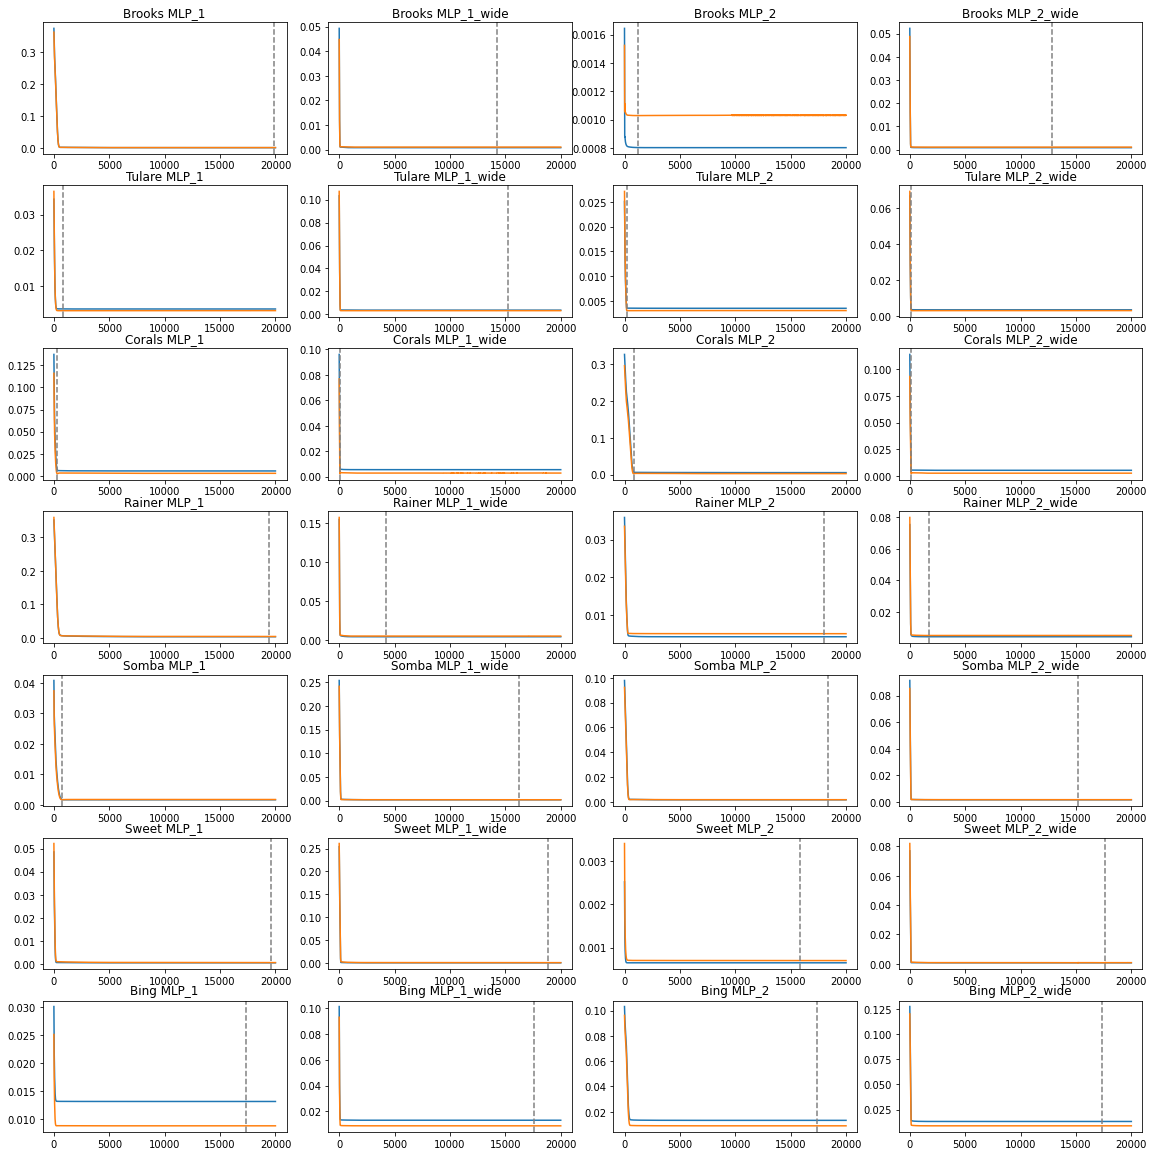

In [ ]:
fig, axs = plt.subplots(7, 4, figsize = (16, 16)) #Subplots/imgsize
fig.tight_layout()
for i, variety in enumerate(results_dict): #Iteration models per variety
  for j, model in enumerate(results_dict[variety]):
    axs[i,j].set_title(variety + " " + model)
    axs[i,j].plot(results_dict[variety][model]["train_loss"], label = "Train Loss")
    axs[i,j].plot(results_dict[variety][model]["val_loss"], label = "Val Loss")
    axs[i,j].axvline(results_dict[variety][model]["epoch_best_model"], c = 'gray', linestyle = "--") #Denoting best epoch
plt.show()
    
    





#### 1.g. Use the best model for model evaluation
- Create a scatterplot of observed versus predicted `dry_matter_ratio` for both training and validation data. Similar to the above, plot each variety in a row (7 total) and each model in a column (4 total), resulting in a 7 x 4 grid of 28 subplots total.
- For each variety x model combination, calculate R2 and RMSE. Add these values as a new entries into your `results_dict` dictionary.

```
variety
 |- model_name
      |- train_loss
      |- val_loss
      |- epoch_best_model
      |- val_best_model
      |- r2_train
      |- r2_val
      |- rmse_train
      |- rmse_val

Building off the illustrative (made up) example earlier, within the Bing variety you might have:

Bing
 |- MLP_1
    |- train_loss: [1.01, 0.67, 0.34 ... 0.01]
    |- val_loss: [1.06, 0.78, 0.42 ... 0.02]
    |- epoch_best_model: 11184
    |- val_best_model: 0.013
    |- r2_train: 0.73
    |- r2_val: 0.68
    |- rmse_train: 0.047
    |- rmse_val: 0.053
```

There will be 27 more entries in `results_dict` like this.

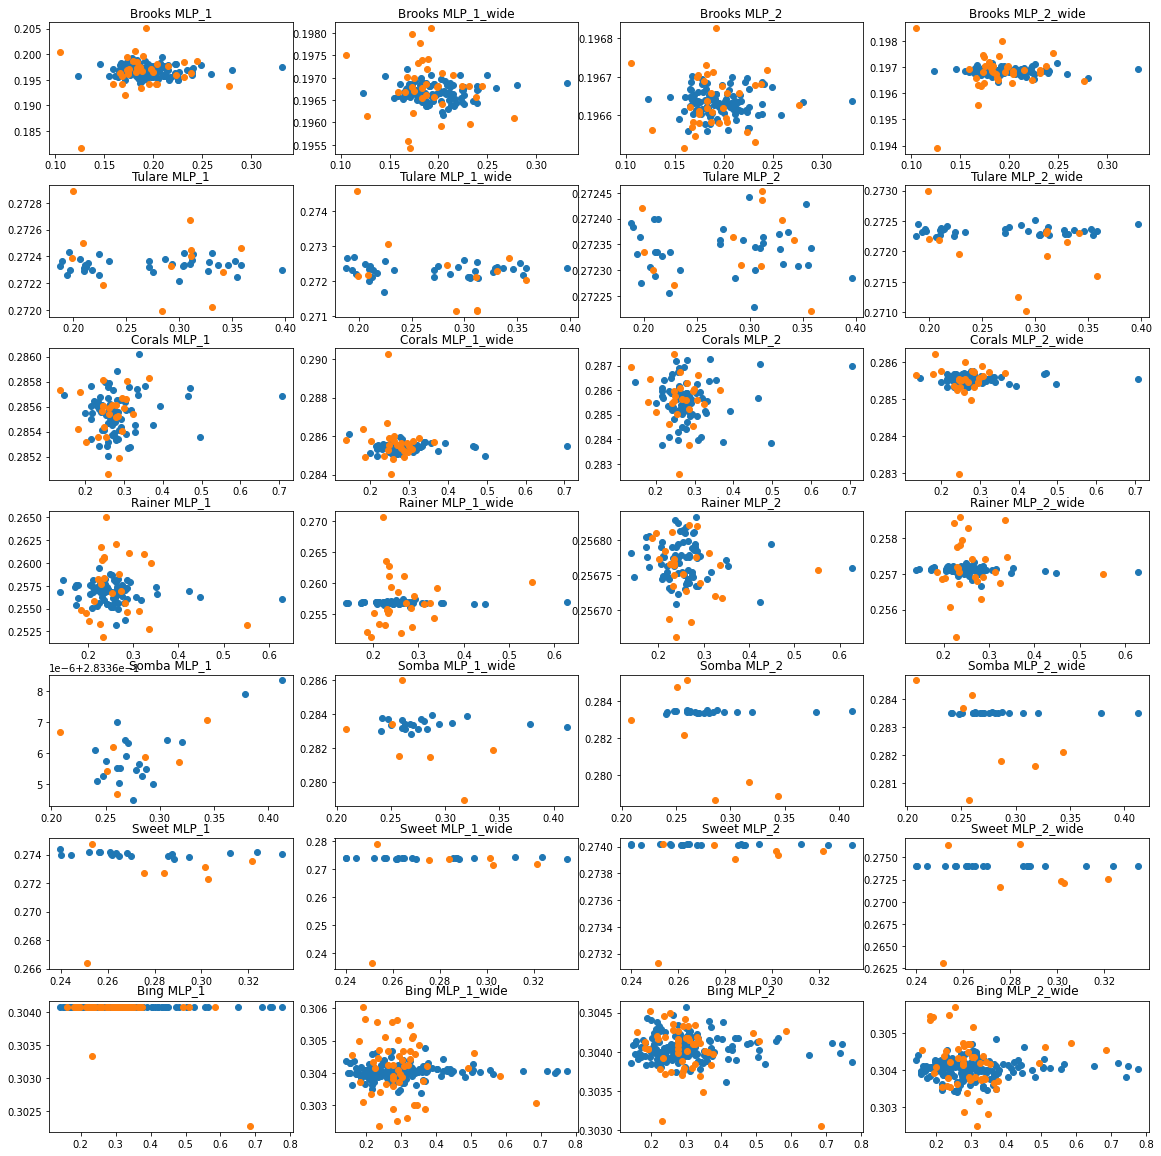

In [ ]:
fig, axs = plt.subplots(7, 4, figsize = (16, 16)) #Sizes
fig.tight_layout()

for i, variety in enumerate(results_dict):
  X = df_cherry[df_cherry['variety']== variety] 
  y = X['dry_matter_ratio']
  X = X.iloc[:,2: ]
  X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 10)
  X_train = torch.tensor(np.array(X_train)).to(dtype = torch.float32)
  X_test = torch.tensor(np.array(X_test)).to(dtype = torch.float32)
  y_test = torch.tensor(np.array(y_test)).to(dtype = torch.float32)
  y_train = torch.tensor(np.array(y_train)).to(dtype = torch.float32)
  for j, model_key in enumerate(results_dict[variety]):
    model = model_dict[model_key](X_train.shape[1])
    model.load_state_dict(torch.load("/content/drive/MyDrive/EBS189A_SINGH_GURTEG/Assignment 7/best_models/" + variety + model_key + ".pt"))
    model.eval()
    pred_train = model(X_train).detach().numpy()
    pred_val = model(X_test).detach().numpy()
    axs[i,j].set_title(variety +" " + model_key)
    results_dict[variety][model_key]["r2_train"] = r2_score(y_train, pred_train) #Accessing Metrics
    results_dict[variety][model_key]["r2_val"] = r2_score(y_test, pred_val)
    results_dict[variety][model_key]["rmse_train"] = mean_squared_error(y_train, pred_train)
    results_dict[variety][model_key]["rmse_val"] = mean_squared_error(y_test, pred_val)
    axs[i,j].scatter( y_train, pred_train, label = "Training Data")
    axs[i,j].scatter( y_test, pred_val, label = "Validation Data")
    
    
plt.show()
    


#### 1.h. Create a Pandas datatable of final results 
- The datatable should have 7 rows, one for each variety, and 6 columns (`variety`, `best_model_name`, `r2_train`, `r2_val`, `rmse_train`, and `rmse_val`). 
- Include only the best model for each variety based on the lowest `rmse_val`. 
- How do these results quantitatively compare to those using linear regression in previous assignments?

In [ ]:
data = []

for variety in results_dict:
  best_model = min(results_dict[variety].keys(), key= lambda x:results_dict[variety][x]["rmse_val"]) #Capturing each variety's metric

  info = [variety, best_model]
  for feature in ["r2_train", "r2_val", "rmse_train", "rmse_val"]:
    info.append(results_dict[variety][best_model][feature]) 
  data.append(info)

df = pd.DataFrame(data, columns= ["variety", "best_model","r2_train", "r2_val", "rmse_train", "rmse_val"])
df









,variety,best_model,r2_train,r2_val,rmse_train,rmse_val
0,Brooks,MLP_1,-0.005964,-0.017916,0.000806,0.001004
1,Tulare,MLP_2,-0.000029,-0.026249,0.003567,0.003110
2,Corals,MLP_2_wide,-0.000033,-0.262218,0.005506,0.002825
3,Rainer,MLP_1_wide,-0.000549,-0.000813,0.004219,0.004962
4,Somba,MLP_1,0.000032,-0.041161,0.001728,0.001816
5,Sweet,MLP_1,-0.002474,-0.172231,0.000650,0.000693
6,Bing,MLP_2_wide,0.000201,-0.002621,0.013191,0.008875
